In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import cv2
from tensorflow.keras import backend as K
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, jaccard_score


# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#            print(os.path.join(dirname, filename))
# os.listdir('/kaggle/input/')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-06-18 04:41:30.056225: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 04:41:30.056372: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 04:41:30.337869: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


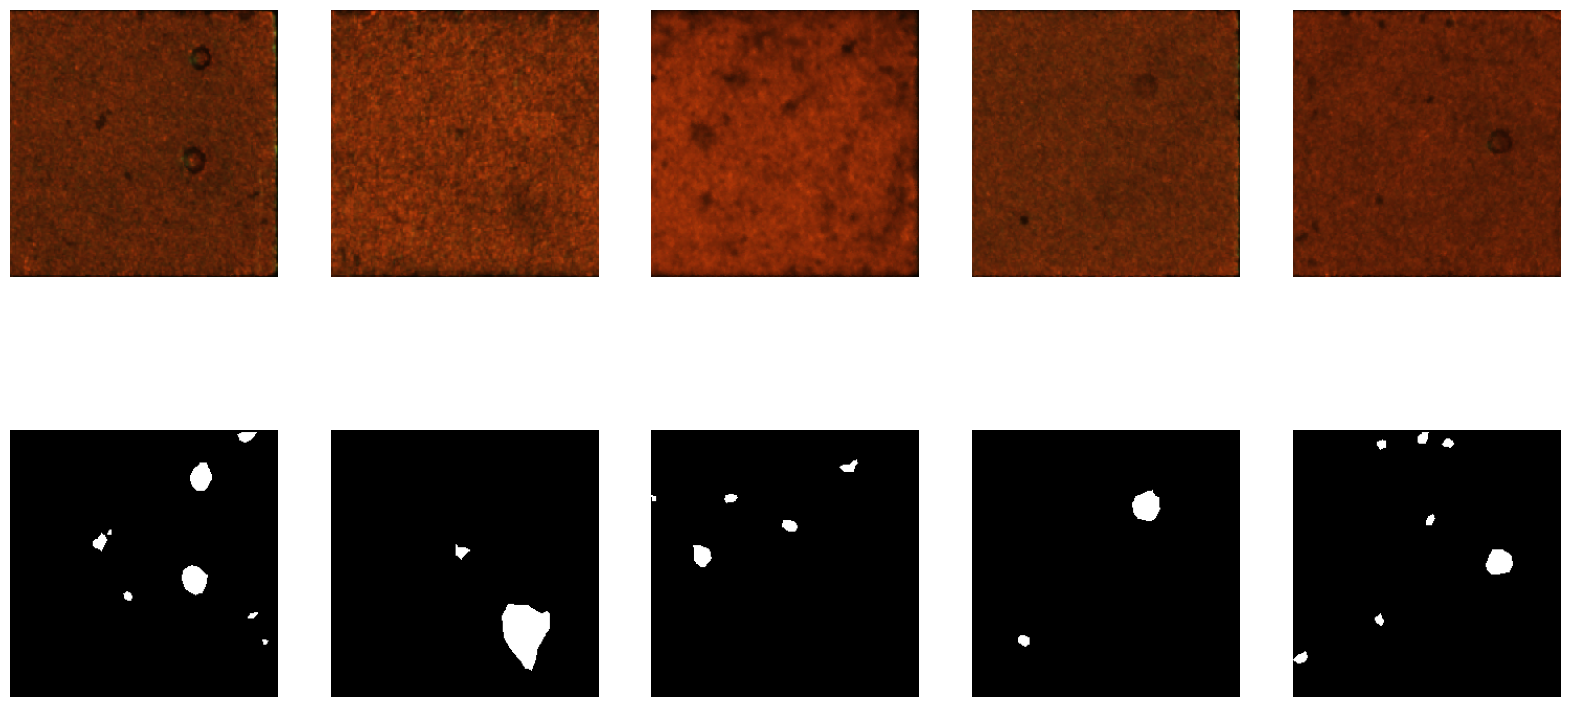

In [2]:
#Contrast enhancement of the labels is required for better readibility of masks
# Define directories (ensure these paths are correct)
image_dir = "/kaggle/input/Heat_Sink_Surface_Defect_Dataset/images"  # Replace with your image directory
mask_dir = "/kaggle/input/Heat_Sink_Surface_Defect_Dataset/labels"   # Replace with your mask directory

# Function to load images and masks with contrast enhancement:
def load_images(image_dir, mask_dir, target_size=(256, 256)):
    images = []
    masks = []
    for img_name in os.listdir(image_dir):
        if img_name.endswith('.bmp'):
            img_path = os.path.join(image_dir, img_name)
            mask_name = img_name.replace('.bmp', '.png')
            mask_path = os.path.join(mask_dir, mask_name)
            if os.path.exists(mask_path):
                img = img_to_array(load_img(img_path, target_size=target_size, color_mode='rgb'))
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, target_size)
                mask = cv2.equalizeHist(mask)
                mask = np.expand_dims(mask, axis=-1)  # Add a channel dimension
                images.append(img)
                masks.append(mask)
    return np.array(images), np.array(masks)

images, masks = load_images(image_dir, mask_dir)

# Normalize images
images = images / 255.0
masks = masks / 255.0

# Ensure masks are binary
masks[masks > 0.5] = 1
masks[masks <= 0.5] = 0

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

# Function to display images and masks
def display_samples(images, masks, n=5):
    plt.figure(figsize=(20, 10))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()

# Display samples
display_samples(X_train, y_train)


In [3]:
#Defining the Model :
from tensorflow.keras.layers import Dropout, BatchNormalization

def unet_model_v2(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    conv5 = Dropout(0.5)(conv5)  # Add dropout
    
    # Decoder
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    
    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    
    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    
    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs=[inputs], outputs=[conv10])
    
    # Use dice loss for better performance
    def dice_coef(y_true, y_pred, smooth=1):
        intersection = K.sum(y_true * y_pred, axis=[1,2,3])
        union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
        return K.mean((2. * intersection + smooth) / (union + smooth), axis=0)
    
    def dice_loss(y_true, y_pred):
        return 1 - dice_coef(y_true, y_pred)
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = unet_model_v2()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16, 16,    │          0 │ conv2d_9[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ dropout[0][0]   

 Total params: 31,378,945 (119.70 MB)

 Trainable params: 31,378,945 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Set up callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
    tf.keras.callbacks.ModelCheckpoint('model.keras', save_best_only=True)
]

# Train the model
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    batch_size=16, 
                    epochs=20, 
                    callbacks=callbacks)


Epoch 1/20


2024-06-18 04:44:06.179016: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,64,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,256,256]{3,2,1,0}, f32[16,64,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-18 04:44:07.107423: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.928539035s
Trying algorithm eng0{} for conv (f32[64,64,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,256,256]{3,2,1,0}, f32[16,64,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-18 04:44:09.672685: E external/

50/50 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.8908 - loss: 2.0824 - val_accuracy: 0.9753 - val_loss: 0.1147
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 748ms/step - accuracy: 0.9733 - loss: 0.1204 - val_accuracy: 0.9753 - val_loss: 0.1103
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 741ms/step - accuracy: 0.9732 - loss: 0.1212 - val_accuracy: 0.9753 - val_loss: 0.1099
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 743ms/step - accuracy: 0.9740 - loss: 0.1138 - val_accuracy: 0.9753 - val_loss: 0.1094
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 741ms/step - accuracy: 0.9736 - loss: 0.1161 - val_accuracy: 0.9753 - val_loss: 0.1078
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 737ms/step - accuracy: 0.9729 - loss: 0.1160 - val_accuracy: 0.9753 - val_loss: 0.1067
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 738ms/step - accuracy: 0.9734 - loss: 0.1129 - val_accuracy: 0.9758 - val_loss: 0.1006
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 732ms/step - accuracy: 0.9757 - loss: 0.1013 - val_accuracy: 0.9765 

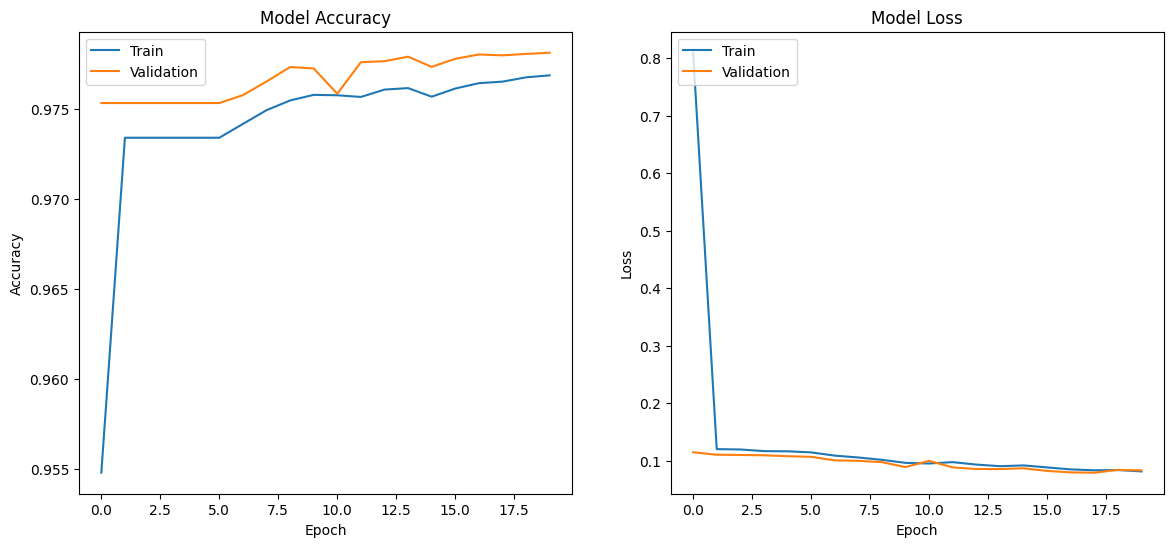

In [5]:
# Import necessary plotting libraries
import matplotlib.pyplot as plt

# Plotting function for training history
def plot_history(history):
    # Check if history contains accuracy and loss values
    if not ('accuracy' in history.history and 'val_accuracy' in history.history):
        print("Error: The training history does not contain accuracy values.")
        return
    if not ('loss' in history.history and 'val_loss' in history.history):
        print("Error: The training history does not contain loss values.")
        return

    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

# Call the plotting function with the training history
plot_history(history)


2024-06-18 04:59:09.556493: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng36{k2=3,k3=0} for conv (f32[32,512,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1536,32,32]{3,2,1,0}, f32[512,1536,3,3]{3,2,1,0}, f32[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-18 04:59:09.613651: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.057326872s
Trying algorithm eng36{k2=3,k3=0} for conv (f32[32,512,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1536,32,32]{3,2,1,0}, f32[512,1536,3,3]{3,2,1,0}, f32[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha"

7/7 ━━━━━━━━━━━━━━━━━━━━ 119s 510ms/step
Measurement Validation Measurement
Accuracy: 0.9781
Precision: 0.7494
Recall: 0.1702
F1 score: 0.2774
IoU: 0.1611


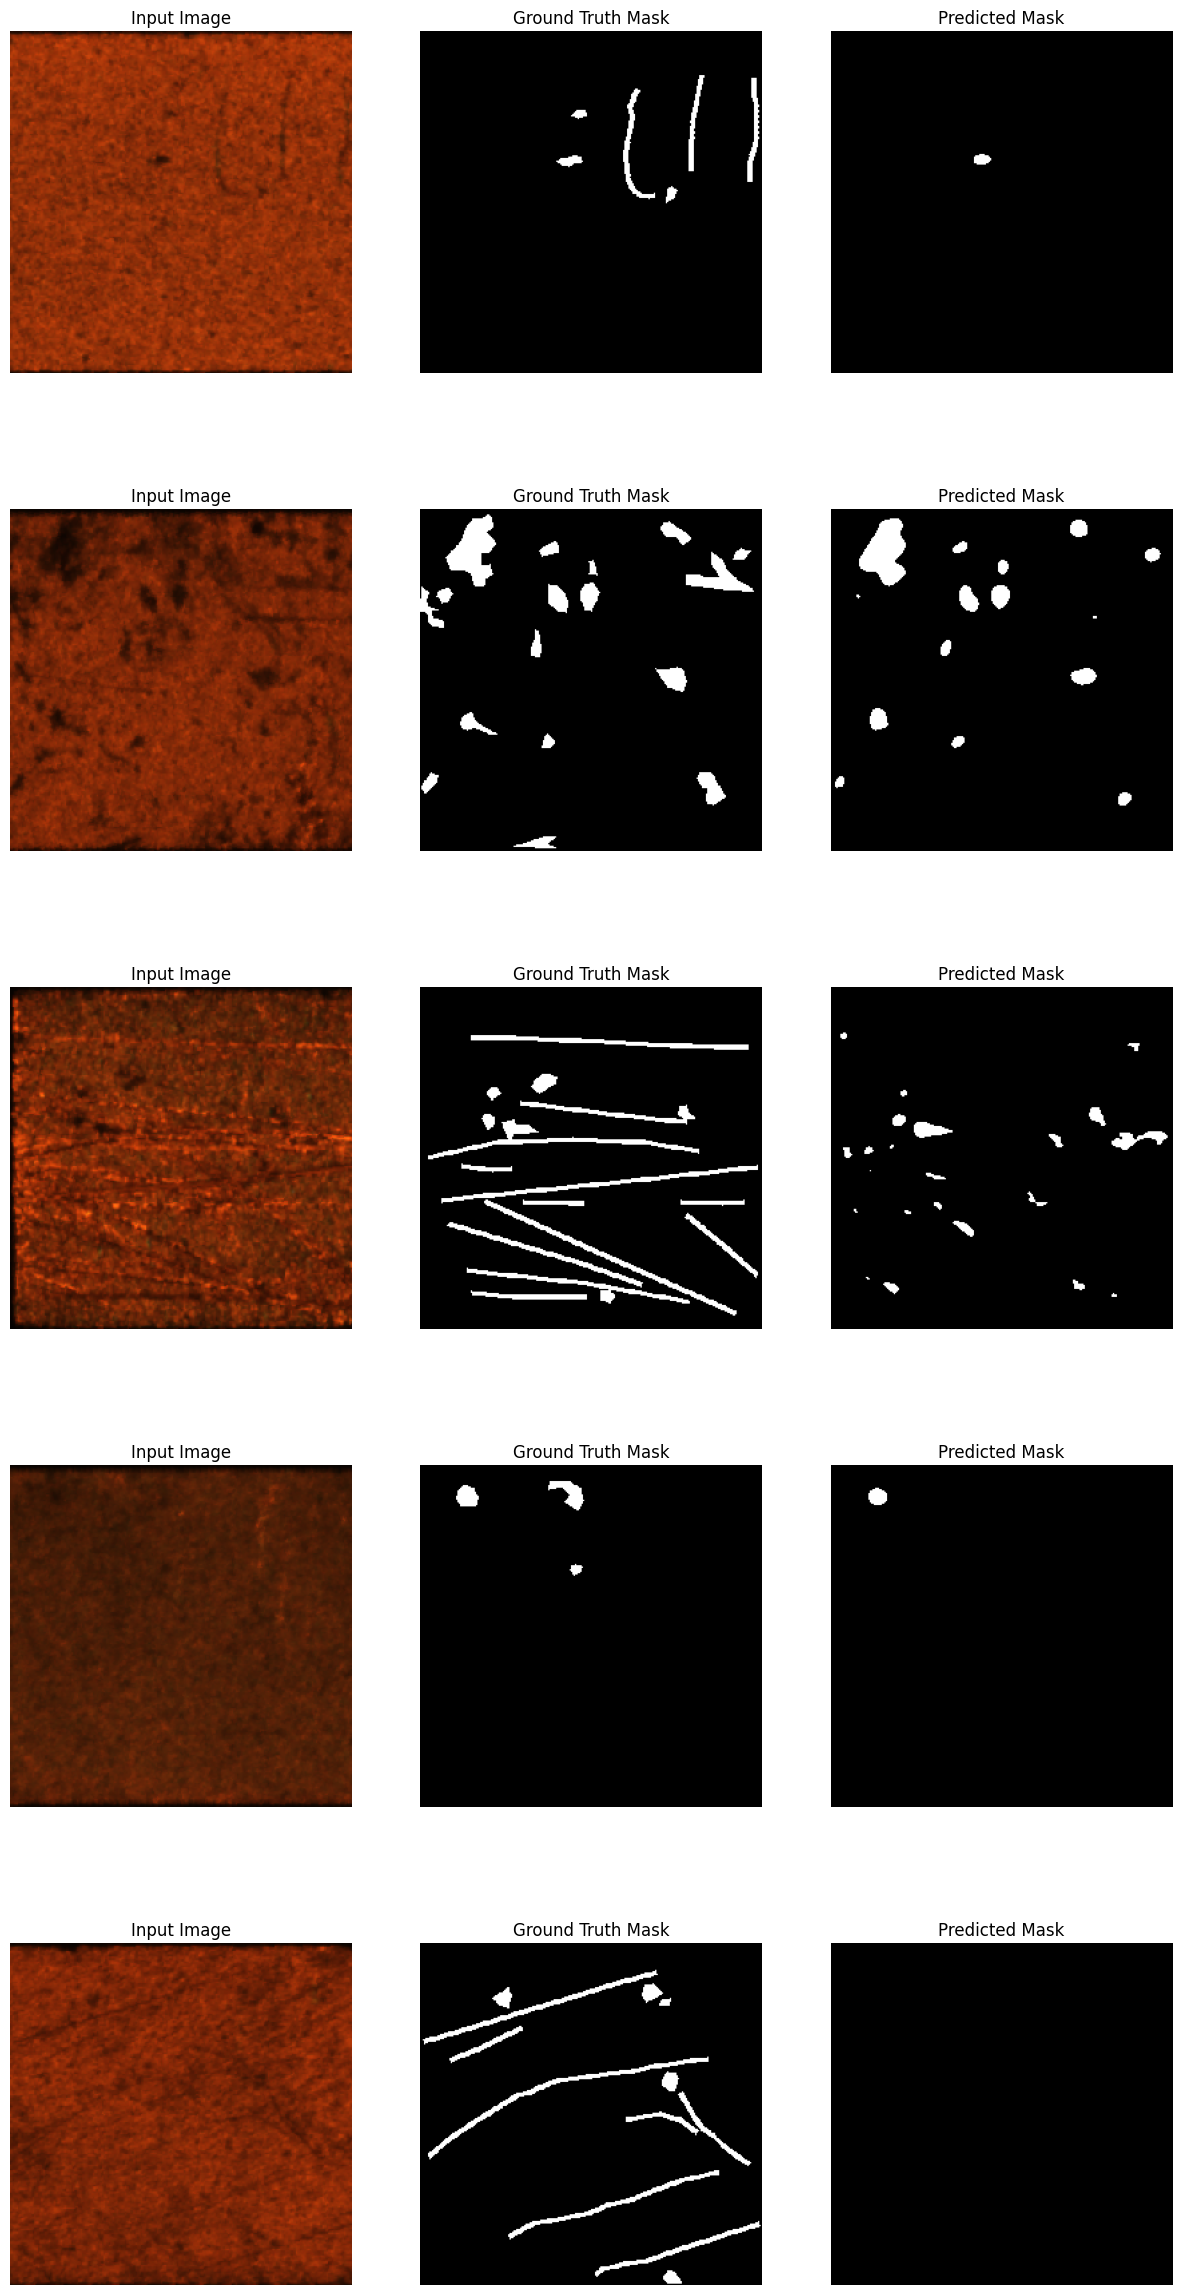

In [6]:
# Define the evaluation function
def evaluate(measurement_name, model, X_test, y_test, threshold=0.5):
    # Predict masks
    y_pred = model.predict(X_test)
    y_pred_binary = (y_pred > threshold).astype(np.uint8)
    
    # Compute evaluation metrics
    accuracy = accuracy_score(y_test.flatten(), y_pred_binary.flatten())
    precision = precision_score(y_test.flatten(), y_pred_binary.flatten())
    recall = recall_score(y_test.flatten(), y_pred_binary.flatten())
    f1 = f1_score(y_test.flatten(), y_pred_binary.flatten())
    iou = jaccard_score(y_test.flatten(), y_pred_binary.flatten())
    
    print("Measurement " + measurement_name)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 score: {f1:.4f}")
    print(f"IoU: {iou:.4f}")
    
    # Visualize results
    num_images = min(5, len(X_test))
    plt.figure(figsize=(15, 6 * num_images))
    
    for i in range(num_images):
        plt.subplot(num_images, 3, 3 * i + 1)
        plt.imshow(X_test[i])
        plt.title('Input Image')
        plt.axis('off')
        
        plt.subplot(num_images, 3, 3 * i + 2)
        plt.imshow(y_test[i].squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')
        
        plt.subplot(num_images, 3, 3 * i + 3)
        plt.imshow(y_pred_binary[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    
    plt.show()

# Test the evaluate function with actual model
evaluate("Validation Measurement", model, X_val, y_val)